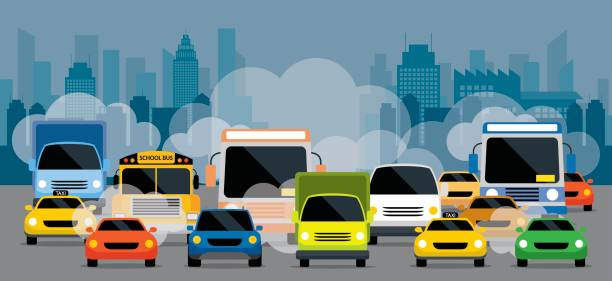

# New York City Taxi Fare Prediction

## Overview
This Notebook will be completed in two main ways.
First, find and visualize useful data or meaningful relationships within the data.
Second, select a model based on the visualization of the previous process. Transform or refine the data into the appropriate form for the model to be used.
<br/><br/>

This is a competition to predict taxi fares in New York. given data contains latitude and longitude. We will predict the result through the boarding position and the disembarkation position. In addition, you can make additional predictions considering the boarding time or boarding date.We need to get New York's latitude and longitude, and remove other values.


##### "In this notebook, New York's longitude and latitude are designated as (40.489707, -74.262378) => (40.937760, -73.698009)"
<br/><br/>

#### My opinion :
1) These data can be visualized as coordinates. So I'm going to visualize where I get in and where I get off a taxi, and then I'm going to visualize a map of New York.<br/>
2) Since taxi time and cost vary from day to day, I think it is better to consider the day of the boarding date to learn about it. ex) Mon, Tue, Wed...

***
## My workflow
#### 1. Import & Install libray
* Import basic libray
* Import Enginnering libray

#### 2. Check out my data
* Check Shape / Info / Describe

#### 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Plot the null values
* Get "Total Distance" Columns (Useing haversine libaray) and Plot it
* Plot the each rows year
* Plot the longitude and latitude per total_distance with [3d interactive Plot]
* Plot the each columns Histogram / Boxplot / Kdeplot


#### 4. Prepocessing Data
* Processing Outlier Values (Out of New York's longitude and latitude)
* In this notebook, New York's longitude and latitude are designated as (40.489707, -74.262378) => (40.937760, -73.698009)

#### 5. Visualization [After Preprocessing]
* Plot the longitude and latitude per total_distance with [3d interactive Plot]
* Plot New York's longitude and latitude against the backdrop of the New York map.

#### 6. Feature Enginnering
* Encoding to Datetime type columns
* Drop unuseful columns

#### 7. Modeling
* * LightGBM Regressor Modeling

#### 8. Submission
* Submit the predictions

# 1. Import & Install libray
* Import basic libray
* Import Enginnering libray
* Install "haversine" libray that, a function to find the distance.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

%matplotlib inline

In [ ]:
pip install haversine

In [ ]:
from haversine import haversine

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [ ]:
train_df = pd.read_csv("/kaggle/input/new-york-city-taxi-fare-prediction/train.csv", nrows= 50000, parse_dates=["pickup_datetime"])
test_df = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv', parse_dates=["pickup_datetime"])
train_df.head()

# 2. Check out my data
* Check Shape / Info / Describe

In [ ]:
train_df.shape

In [ ]:
train_df.info()

In [ ]:
train_df.describe()

In [ ]:
Spectral_palette = sns.color_palette("Spectral", 10)
sns.palplot(Spectral_palette)

# 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Plot the null values
* Get "Total Distance" Columns (Useing haversine libaray) and Plot it
* Plot the each rows year
* Plot the longitude and latitude per total_distance with [3d interactive Plot]
* Plot the each columns Histogram / Boxplot / Kdeplot

### 3-1) Plot the null values


In [ ]:
train_df.head()

In [ ]:
f, ax = plt.subplots(1,1, figsize=(8,6))
msno.bar(train_df, ax=ax, color=Spectral_palette[7])
plt.title('Null Values')
plt.show()

In [ ]:
pd.DataFrame(train_df.isnull().sum(), columns=["Train Null Count"])

In [ ]:
pd.DataFrame(test_df.isnull().sum(), columns=["Test Null Count"])

In [ ]:
train_df.head()

### 3-2)  Get "Total Distance" Columns (Useing haversine libaray) and Plot it

In [ ]:
def get_total_distance(df):
    a1 = df['pickup_latitude']
    a2 = df['dropoff_latitude']
    
    b1 = df['pickup_longitude']
    b2 = df['dropoff_longitude']

    pick_up = (a1, b1) 
    drop_off = (a2, b2)
    return haversine(pick_up, drop_off)
    # haversine function : Get Distance to use x(latitude, longitude), y(latitude, longitude)

-> When you need Total Distance, Then you can use this function

In [ ]:
train_df['total_distance'] = train_df.apply(lambda x: get_total_distance(x),axis=1)
test_df['total_distance'] = test_df.apply(lambda x: get_total_distance(x),axis=1)
train_df.head()

In [ ]:
Spectral_palette

In [ ]:
fig = plt.figure(figsize=(8,9))

for i in range(2):
    plt.subplot(2, 1, i+1)
    plt.title("Train Data index {} | Distance :{:.3f}".format(i, train_df['total_distance'][i]))
    plt.scatter(train_df['pickup_longitude'][i], train_df['pickup_latitude'][i], color=Spectral_palette[1], label="Pick up location")
    plt.scatter(train_df['dropoff_longitude'][i], train_df['dropoff_latitude'][i], color=Spectral_palette[-1], label="Drop off location")
    plt.plot([train_df['pickup_longitude'][i],train_df['dropoff_longitude'][i]],[train_df['pickup_latitude'][i],train_df['dropoff_latitude'][i]],'k:')
    plt.axis('off')
    plt.legend()
    
fig.text(0.05,0.95,"Length by pickup location and drop off location", fontweight="bold", fontfamily='serif', fontsize=20)
plt.show()

### 3-3) Plot the longitude and latitude per total_distance with [3d interactive Plot]

* (pickup_longitude, dropoff_longitude) per fare_amount

In [ ]:
f = px.scatter_3d(train_df[:10000], x='pickup_latitude', y='pickup_longitude', z='total_distance',
                    color='fare_amount')
f.show()

In [ ]:
f = px.scatter_3d(train_df[:10000], x='dropoff_latitude', y='dropoff_longitude', z='total_distance',
                    color='fare_amount')
f.show()

#### => Looking at the graph above, no significant results can be found. <br/> So after the preprocessing process, I plan to visualize it again.

### 3-4) Plot the each rows year

In [ ]:
train_df['pickup_datetime_year'] = train_df['pickup_datetime'].dt.year
train_df.head()

In [ ]:
train_df['pickup_datetime_year'].value_counts()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6, 4), constrained_layout=True)

ax = sns.countplot(train_df['pickup_datetime_year'], palette=Spectral_palette)
ax.patch.set_alpha(0)
ax.set_xlabel("")
ax.set_ylabel("")
fig.text(0.08,1.03,"Count of data by year", fontweight="bold", fontfamily='serif', fontsize=18)
plt.show()

### 3-5) Plot the each columns Histogram / Boxplot / Kdeplot

In [ ]:
df_index =[1,3,4,5,6,7]
fig = plt.figure(figsize=(10,8))

for num, i in enumerate(df_index):
    plt.subplot(3,2,num+1)
    plt.title("{} Column".format(train_df.columns[i]))
    plt.boxplot(train_df.iloc[:,i])

fig.text(0.08,0.94,"Boxplot the each columns", fontweight="bold", fontfamily='serif', fontsize=18)
plt.show()

Spectral_palette

In [ ]:
df_index =[1,3,4,5,6,7]
fig = plt.figure(figsize=(12,8))

for num, i in enumerate(df_index):
    plt.subplot(2, 3,num+1)
    plt.title("{} Column".format(train_df.columns[i]))
    plt.hist(train_df.iloc[:,i], color=Spectral_palette[num])

fig.text(0.08,0.94,"Histogram the each columns", fontweight="bold", fontfamily='serif', fontsize=18)
plt.show()

In [ ]:
df_index =[1,3,4,5,6,7]
fig = plt.figure(figsize=(14,10))

for num, i in enumerate(df_index):
    plt.subplot(2,3,num+1)
    plt.title("{} Column".format(train_df.columns[i]))
    sns.kdeplot(train_df.iloc[:,i], fill=True, lw=1.7, alpha=0.7, color=Spectral_palette[num+4])

fig.text(0.08,0.94,"KdePlot the each columns", fontweight="bold", fontfamily='serif', fontsize=18)
plt.show()

# 4. Prepocessing Data
* Processing Outlier Values (Out of New York's longitude and latitude)

=>In this notebook, New York's longitude and latitude are designated as (40.489707, -74.262378) => (40.937760, -73.698009)

##### About New York's latitude / longitude <br/>
* latitude  	40°29'40"N - 45°0'42"N (~40.6643)
* longitude 	71°47'25"W - 79°45'54"W (~-73.9385)
* This notebook will use (latitude, longitude) / (40.489707, -74.262378) => (40.937760, -73.698009)

### 4-1) Processing Outlier Values

In [ ]:
def data_cleansing(df, data="Train"):
    
    print("Before cleansing shape : {}".format(df.shape))
    print("----- CLEANSING -----")
    
    if data=="Train":
        df = df.drop(df[df['fare_amount'] <= 2].index)
        df = df.drop(df[df['fare_amount'] >= 100].index)
        print(df.shape)
    
    df = df.drop(df[df['pickup_longitude'] <= -74.5].index)
    df = df.drop(df[df['pickup_longitude'] >= -73.5].index)
    print(df.shape)
   
    df = df.drop(df[df['pickup_latitude'] <= 40.4].index)
    df = df.drop(df[df['pickup_latitude'] >= 41].index)
    print(df.shape)
   
    df = df.drop(df[df['dropoff_longitude'] <= -74.5].index)
    df = df.drop(df[df['dropoff_longitude'] >= -73.5].index)
    print(df.shape)
   
    df = df.drop(df[df['dropoff_latitude'] <= 40.4].index)
    df = df.drop(df[df['dropoff_latitude'] >= 41].index)
    print(df.shape)
       
    # No more than 7 passengers are allowed on board.
    df = df.drop(df[df['passenger_count'] <= 0].index)
    df = df.drop(df[df['passenger_count'] >= 7].index)
    
    print("----- CLEANSING -----")
    print("After cleansing shape : {}".format(df.shape))
    
    return df

In [ ]:
train_df['fare_amount'].sort_values(ascending=False)

In [ ]:
train_df = data_cleansing(train_df, "Train")

# 5. EDA with Visualization [After Preprocessing]
* Plot the longitude and latitude per total_distance with [3d interactive Plot]
* Plot New York's longitude and latitude against the backdrop of the New York map.

### 5-1) Plot the longitude and latitude per total_distance with [3d interactive Plot]

In [ ]:
f = px.scatter_3d(train_df[:10000], x='pickup_latitude', y='pickup_longitude', z='total_distance',
                    color='fare_amount')
f.show()

In [ ]:
f = px.scatter_3d(train_df[:10000], x='dropoff_latitude', y='dropoff_longitude', z='total_distance',
                    color='fare_amount')
f.show()

In [ ]:
map_img = plt.imread('../input/google-map-nyc-40474541735-kor-version/google_map_NYC_(40.4-74.541-73.5)_KOR_VERSION.png')

In [ ]:
plt.imshow(map_img)
plt.show()

### 5-2) Plot New York's longitude and latitude against the backdrop of the New York map.
##### You can use this img
* Add data => Search the "google_mapNYC(40.4-74.541-73.5)_KOR_VERSION.png"

In [ ]:
def plot_map(df, map_img, s=10, alpha=0.2):
    f, ax = plt.subplots(1, 2, figsize=(16,8))
    ax[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    ax[0].set_xlim(-74.5, -73.5)
    ax[0].set_ylim((40.4, 41))
    ax[0].set_title('Pickup locations')
    ax[0].axis('off')
    ax[0].imshow(map_img, zorder=0, extent=(-74.5, -73.5, 40.4, 41))

    ax[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    ax[1].set_xlim(-74.5, -73.5)
    ax[1].set_ylim((40.4, 41))
    ax[1].set_title('Dropoff locations')
    ax[1].axes.xaxis.set_visible(False)
    ax[1].axes.yaxis.set_visible(False)
    ax[1].imshow(map_img, zorder=0, extent=(-74.5, -73.5, 40.4, 41))

In [ ]:
plot_map(train_df[:1000], map_img)

# 6. Feature Enginnering
* Encoding to Datetime type columns
* Drop unuseful columns

In [ ]:
train_df.head()

### 6-1) Encoding to Datetime type columns

In [ ]:
train_df["year"] = train_df["pickup_datetime"].dt.year
train_df["weekday"] = train_df["pickup_datetime"].dt.weekday
train_df["hour"] = train_df["pickup_datetime"].dt.hour

test_df["year"] = test_df["pickup_datetime"].dt.year
test_df["weekday"] = test_df["pickup_datetime"].dt.weekday
test_df["hour"] = test_df["pickup_datetime"].dt.hour

In [ ]:
train_df.head()

In [ ]:
test_df.head()

### 6-2) Drop useful Columns

In [ ]:
train_df.drop(['key','pickup_datetime','pickup_datetime_year'], axis=1, inplace=True)
test_df.drop(['key','pickup_datetime'], axis=1, inplace=True)
train_df.head()

In [ ]:
train_df.info()

# 7. Modeling
* LightGBM Regressor Modeling
* Divide the data into training, testing and evaluation
* Training
* Evaluating

### 7-1) Divide the data into training, testing and evaluation

In [ ]:
x = train_df.drop('fare_amount', axis=1)
y = train_df['fare_amount']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print("X train data shape : {}".format(x_train.shape))
print("Y train data shape : {}".format(y_train.shape))

print("X test data shape : {}".format(x_test.shape))
print("Y test data shape : {}".format(y_test.shape))

In [ ]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.6)
print("X validation data shape : {}".format(x_val.shape))
print("Y validation data shape : {}".format(y_val.shape))

print("X test data shape : {}".format(x_test.shape))
print("Y test data shape : {}".format(y_test.shape))

#### - Lgbm Regressor

### 7-2) Training

In [ ]:
train_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(x_val, label=y_val)

In [ ]:
params = {
    'n_estimators': 5000,
    'num_leaves': 500,
    'max_depth': -1,
    'min_data_in_leaf': 1000,
    'learning_rate': 0.003,
    'boosting': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'Is_training_metric': True,
    'n_jobs': -1
}

In [ ]:
model = lgb.train(params,
                  train_data,
                  valid_sets=val_data, 
                  valid_names=['train','valid'],
                  early_stopping_rounds=100)

### 7-3) Evaluating

In [ ]:
print('Starting predicting...')
# predict
y_pred = model.predict(x_test)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred))

# 8. Submission
* Submit the predictions

In [ ]:
submission = pd.read_csv('../input/new-york-city-taxi-fare-prediction/sample_submission.csv')
submission.head()

In [ ]:
submission.shape

In [ ]:
pred = model.predict(test_df)

In [ ]:
print(pred[:10])

In [ ]:
submission['fare_amount'] = pred

In [ ]:
submission.to_csv("submission.csv", index=False)

##### Reference
* https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration
* http://egloos.zum.com/incredible/v/7479081

###  If this notebook is useful for your kaggling, "UPVOTE" for it 👀
#### THX to Reading My Notebook🌈